# Различные алгоритмы для сегментации клеток по мембранным маркерам и ядер по DAPI
**Идея:** использовать сегментацию мембран для последующей сегментации клеток. Забегая вперед данная идея провалилась ввиду того, что часть клеток не имеют выраженной мембранной окраски, а при этом клетки есть. Следовательно, при подсчетет статистики полученные результаты будут искажены. Также сегментация клеток по мембранным маркерам представляется сложной ввиду незамкнутости контуров у части клеток и разделение слипшихся кластеров представляется затруднительным.
В результате **идея** трансформировалась в сегментацию ядер, разделение кластеров и последующий подсчет статистики в некоторой области ядер с использованием расширения меток *expand_labels*

In [1]:
from img_with_bw_boundaries import *

In [2]:
# Загрузка изображений после предобработки
from load_imgs_from_folder import *
imgs_names, imgs = load_images_from_folder(r'tiled_data', ['Stitched_cropped_preprocessed'], '*.tif')

In [3]:
imgs_names

['pano_CD3e.tif',
 'pano_CD4.tif',
 'pano_CD8.tif',
 'pano_DAPI.tif',
 'pano_Ki67.tif',
 'pano_Membrane_summary.tif']

In [4]:
I_membrane = imgs[-1]
I_nuclei = imgs[3]

# Сегментация мембран

## Сегментация областей

### ISODATA

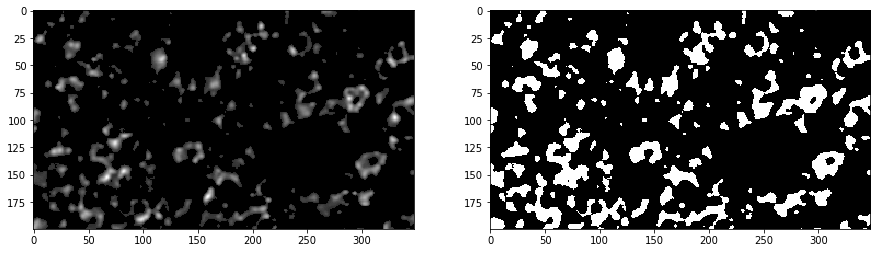

In [5]:
from skimage.filters import threshold_isodata
thresh_ISODATA = threshold_isodata(I_membrane)
BW_ISODATA = I_membrane > thresh_ISODATA
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
I_dif_ISODATA = np.multiply(I_membrane, np.uint8(BW_ISODATA))
axes[0].imshow(I_dif_ISODATA[0:200,1200:], cmap='gray')
axes[1].imshow(BW_ISODATA[0:200,1200:], cmap='gray')

### Li

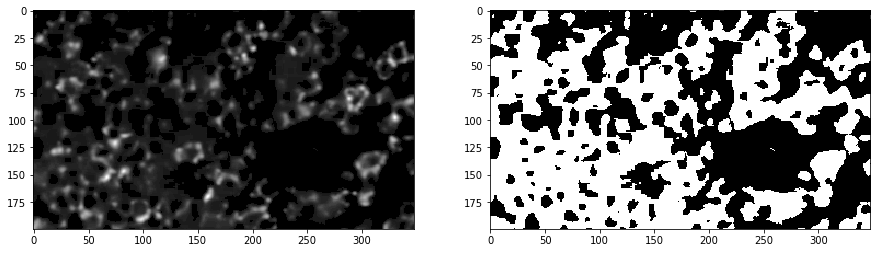

In [6]:
from skimage.filters import threshold_li
thresh_li = threshold_li(I_membrane)
BW_li = I_membrane > thresh_li
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
I_dif_li = np.multiply(I_membrane, np.uint8(BW_li))
axes[0].imshow(I_dif_li[0:200,1200:], cmap='gray')
axes[1].imshow(BW_li[0:200,1200:], cmap='gray')

### Локальная (адаптивная) бинаризация
Метод имеет ряд параметров: <br />
**block_size** - нечетное число, определяющее размер окна, в котором происходит вычисление <br />
**method** - ‘generic’, ‘gaussian’, ‘mean’, ‘median’ метод обсчета внутри окна<br />
**offset** - смещение, вычитаемое из взвешенного среднего внутри окна<br />
**mode** - ‘reflect’, ‘constant’, ‘nearest’, ‘mirror’, ‘wrap’ режим работы с границей<br />
**param** - для гауссового фильтра задает сигму, а для собственной функции generic задает имя самой функции<br />
<br />
Для определения оптимальной комбинации сначала выберем метод, потом режим работы с границей, потом размер окна и смещение

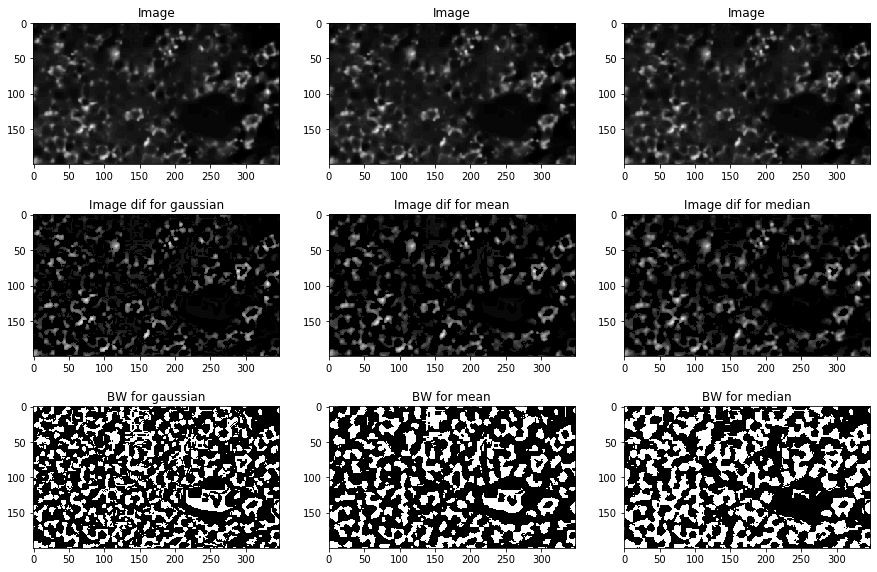

In [8]:
# Выбор метода
import matplotlib.pyplot as plt
from skimage.filters import threshold_local

methods = ['gaussian', 'mean', 'median']
fig, axes = plt.subplots(3, len(methods), figsize=(15, 10))
for idx, cur_method in enumerate(methods):
    BW = I_membrane > threshold_local(I_membrane, block_size = 21, offset=0, method=cur_method)
    I_dif = np.multiply(I_membrane, (np.uint8(BW)))
    axes[0, idx].imshow(I_membrane[0:200,1200:], cmap='gray')
    axes[0, idx].set_title("Image")
    axes[1, idx].imshow(I_dif[0:200,1200:], cmap='gray')
    axes[1, idx].set_title("Image dif for " + methods[idx])
    axes[2, idx].imshow(BW[0:200,1200:], cmap='gray')
    axes[2, idx].set_title("BW for " + methods[idx])

**Вывод**
Как видно из приведенных выше изображений при прочих равных Гауссов метод дает большое число тонких линий, которые можно в последствии убрать морфологиескими операциями, однако дает большое число разомкнутых сегментов, которые при применении морфологических операций также можно устранить с помощью closing или filate, но при обратном переходе с помощью opening или erosion часть. Основной недостаток ложное детектирование в правой нижней части изображения, но это возможно исправить, поварьировав размеры окна и сигмы. Остальные два метода сильно утолщают границы, принимая фон за наличие экспрессии мембранного маркера

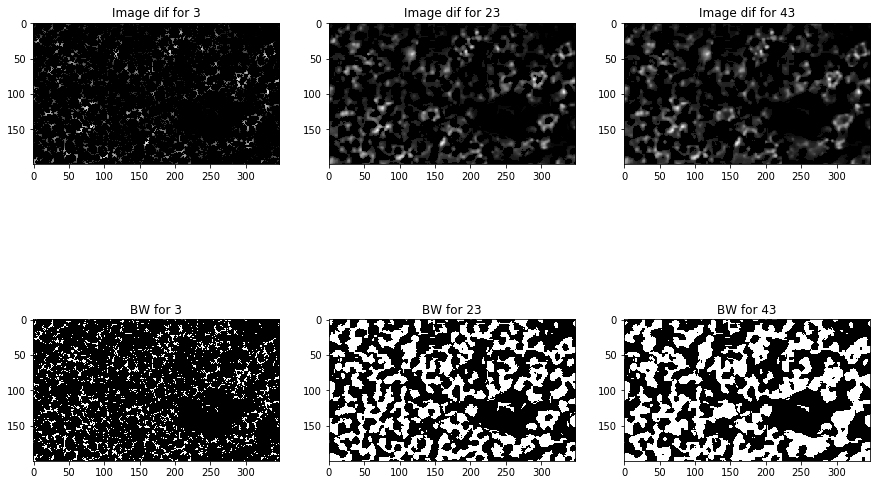

In [9]:
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_local

fig, axes = plt.subplots(2, len(range(3, 44, 20)), figsize=(15, 10))
for idx, block_size in enumerate(range(3, 44, 20)): # можно поварьировать и проследить изменения
    BW = I_membrane > threshold_local(I_membrane, block_size, offset=0, method='median')
    I_dif = np.multiply(I_membrane, (np.uint8(BW)))
    axes[0, idx].imshow(I_dif[0:200,1200:], cmap='gray')
    axes[0, idx].set_title("Image dif for " + str(block_size))
    axes[1, idx].imshow(BW[0:200,1200:], cmap='gray')
    axes[1, idx].set_title("BW for " + str(block_size))

# Сегментация ядер

### ISODATA

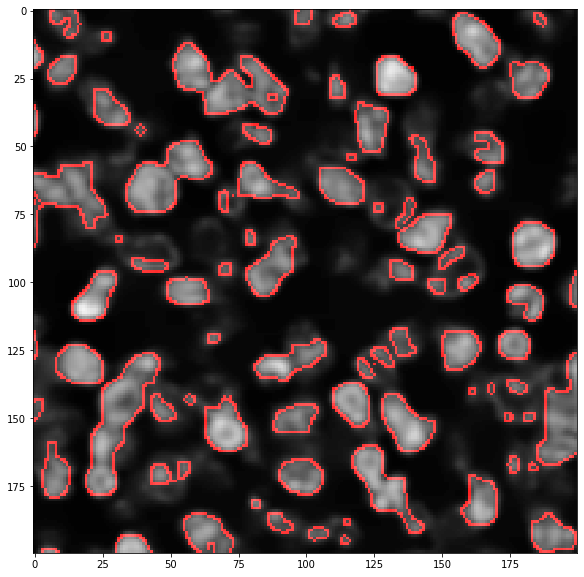

In [10]:
from skimage.filters import threshold_isodata
thresh_isodata = threshold_isodata(I_nuclei)
BW_isodata = I_nuclei > thresh_isodata
fig, axes = plt.subplots(figsize=(15, 10))
axes.imshow(img_with_bw_boundaries(I_nuclei, BW_isodata)[400:600, 400:600, :])

### Li

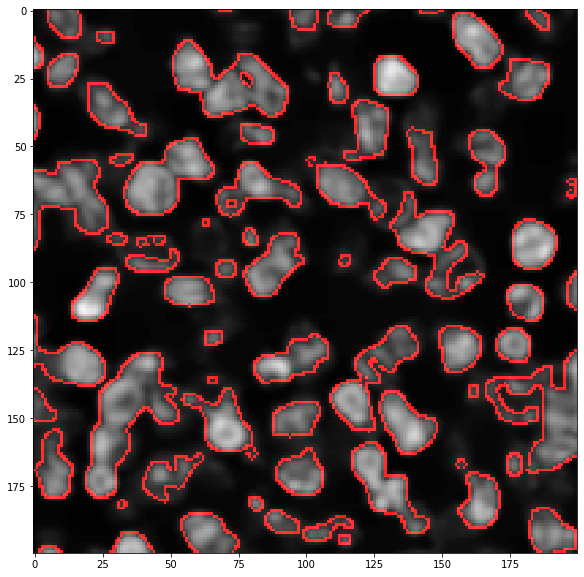

In [11]:
from skimage.filters import threshold_li
thresh_li = threshold_li(I_nuclei)
BW_li = I_nuclei > thresh_li
fig, axes = plt.subplots(figsize=(15, 10))
axes.imshow(img_with_bw_boundaries(I_nuclei, BW_li)[400:600, 400:600, :])

### Локальная (адаптивная) бинаризация
Метод имеет ряд параметров: <br />
**block_size** - нечетное число, определяющее размер окна, в котором происходит вычисление <br />
**method** - ‘generic’, ‘gaussian’, ‘mean’, ‘median’ метод обсчета внутри окна<br />
**offset** - смещение, вычитаемое из взвешенного среднего внутри окна<br />
**mode** - ‘reflect’, ‘constant’, ‘nearest’, ‘mirror’, ‘wrap’ режим работы с границей<br />
**param** - для гауссового фильтра задает сигму, а для собственной функции generic задает имя самой функции<br />
<br />
Для определения оптимальной комбинации сначала выберем метод, потом размер окна и смещение. Режим работы с границей оставим по умолчанию, так как отражение является оптимальным с точки зрения отсутствия краевых эффектов при фильтрации.

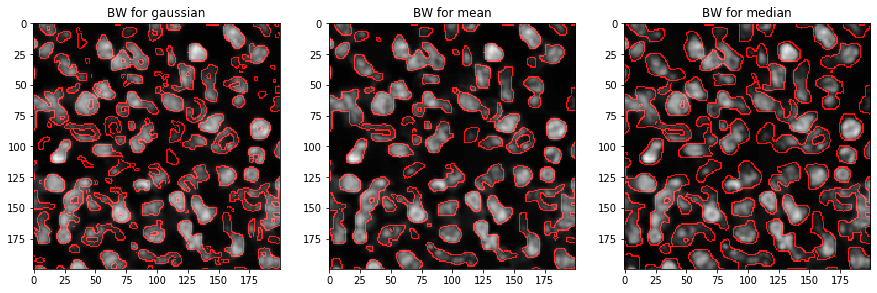

In [12]:
# Выбор метода
import matplotlib.pyplot as plt
from skimage.filters import threshold_local

methods = ['gaussian', 'mean', 'median']
fig, axes = plt.subplots(1, len(methods), figsize=(15, 5))
for idx, cur_method in enumerate(methods):
    BW_local = I_nuclei > threshold_local(I_nuclei, block_size = 21, offset=0, method=cur_method)
    axes[idx].imshow(img_with_bw_boundaries(I_nuclei, BW_local)[400:600, 400:600, :])
    axes[idx].set_title("BW for " + methods[idx])

**Вывод**
Выбираем медианную фильтрацию, так как она довольно точно описывает контуры ядер и при этом не дает большого числа мелких отдельных элементов (правда их можно устранить)

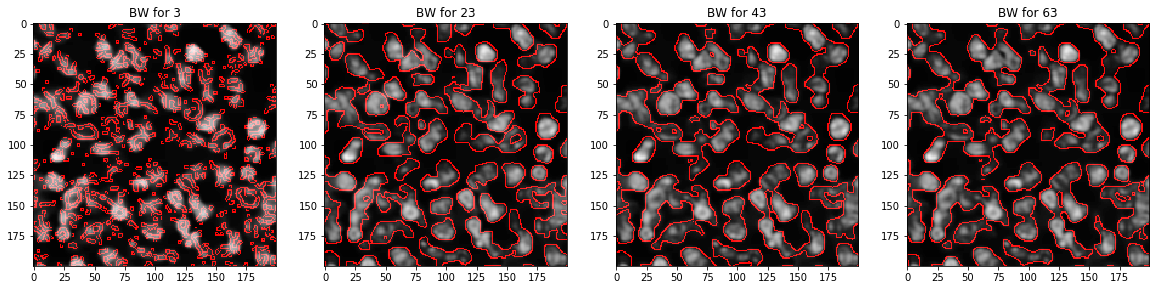

In [13]:
import matplotlib.pyplot as plt
from skimage.filters import threshold_local

fig, axes = plt.subplots(1, len(range(3, 64, 20)), figsize=(20, 10))
for idx, cur_block_size in enumerate(range(3, 64, 20)): # можно поварьировать и проследить изменения
    BW_local = I_nuclei > threshold_local(I_nuclei, block_size=cur_block_size, offset=0, method='median')
    axes[idx].imshow(img_with_bw_boundaries(I_nuclei, BW_local)[400:600, 400:600, :])
    axes[idx].set_title("BW for " + str(cur_block_size))

**Вывод**
Выбираем размер блока 23, так как он является оптимальным с точки зрения отсутствия мелких компонентов, при этом точнее всего описывает контуры кластеров

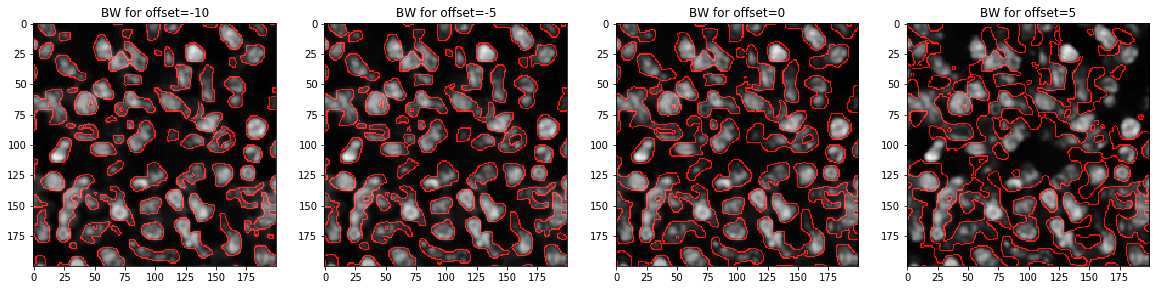

In [14]:
import matplotlib.pyplot as plt
from skimage.filters import threshold_local

fig, axes = plt.subplots(1, len(range(-10, 6, 5)), figsize=(20, 10))
for idx, cur_offset in enumerate(range(-10, 6, 5)):
    BW_local = I_nuclei > threshold_local(I_nuclei, block_size=23, offset=cur_offset, method='median')
    axes[idx].imshow(img_with_bw_boundaries(I_nuclei, BW_local)[400:600, 400:600, :])
    axes[idx].set_title("BW for offset=" + str(cur_offset))

**Вывод**
Выбираем offset = 0, так как он не вносит дополнительной "эрозии" областей

In [15]:
BW_local = I_nuclei > threshold_local(I_nuclei, block_size=23, offset=0, method='median')

### Mean

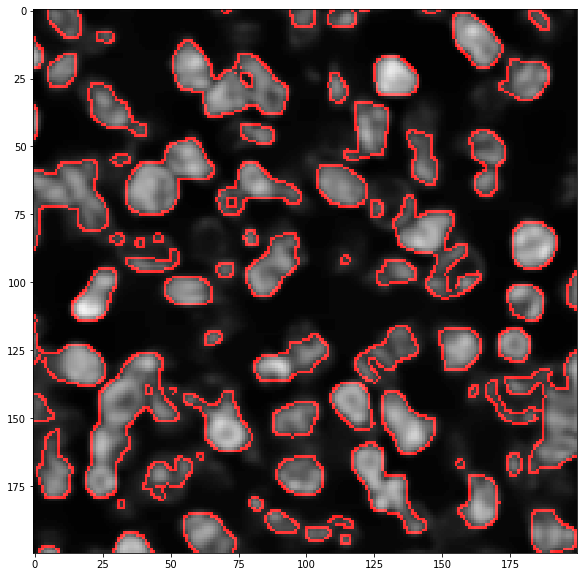

In [16]:
from skimage.filters import threshold_mean
thresh_mean = threshold_mean(I_nuclei)
BW_mean = I_nuclei > thresh_mean
fig, axes = plt.subplots(figsize=(15, 10))
axes.imshow(img_with_bw_boundaries(I_nuclei, BW_mean)[400:600, 400:600, :])

### Minimum

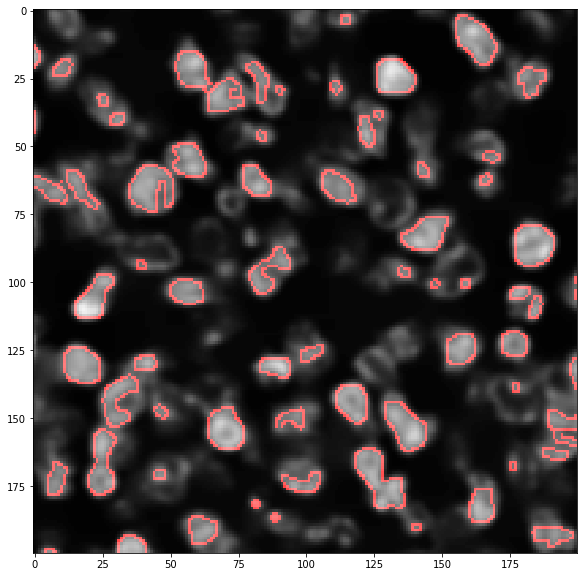

In [17]:
from skimage.filters import threshold_minimum
thresh_minimum = threshold_minimum(I_nuclei)
BW_minimum = I_nuclei > thresh_minimum
fig, axes = plt.subplots(figsize=(15, 10))
axes.imshow(img_with_bw_boundaries(I_nuclei, BW_minimum)[400:600, 400:600, :])

### Multiotsu
В версии библиотеки, доступной для Anaconda (0.15.0) такого метода нет, в люом случае при числе классов равном 2 данный метод аналогичен Отсу

In [18]:
# from skimage.filters import threshold_multiotsu
# thresh_multiotsu = threshold_multiotsu(I_nuclei)
# BW_multiotsu = I_nuclei > thresh_multiotsu
# fig, axes = plt.subplots(figsize=(15, 10))
# axes.imshow(img_with_bw_boundaries(I_nuclei, BW_multiotsu)[400:600, 400:600, :])

### Niblack
Есть параметр - размер окна, выберем наиболее оптимальное значение

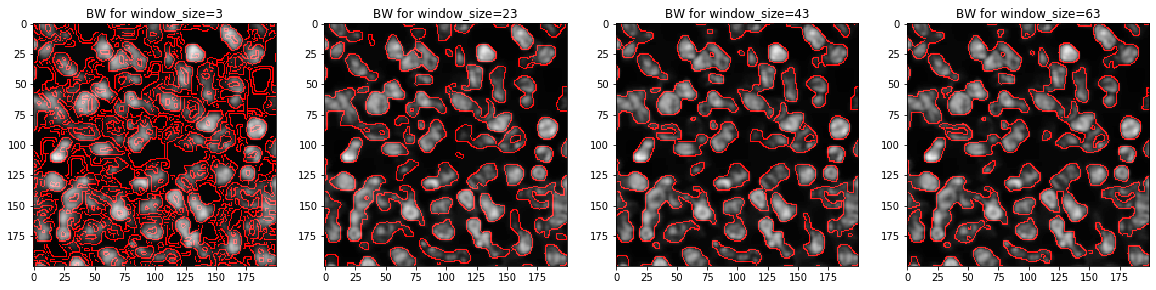

In [19]:
from skimage.filters import threshold_niblack
fig, axes = plt.subplots(1, len(range(3, 64, 20)), figsize=(20, 10))
for idx, size in enumerate(range(3, 64, 20)):
    thresh_niblack = threshold_niblack(I_nuclei, window_size=size)
    BW_niblack = I_nuclei > thresh_niblack
    axes[idx].imshow(img_with_bw_boundaries(I_nuclei, BW_niblack)[400:600, 400:600, :])
    axes[idx].set_title("BW for window_size=" + str(size))

**Выводы**
Наилучшим размером окна является 23, так как это не приводит к избыточности контуров и не приводит к избыточной кластеризации

In [20]:
thresh_niblack = threshold_niblack(I_nuclei, window_size=23)
BW_niblack = I_nuclei > thresh_niblack

### Otsu

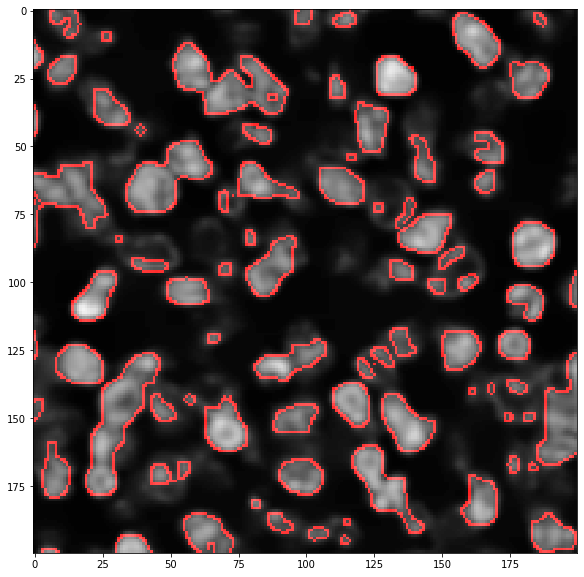

In [21]:
from skimage.filters import threshold_otsu
thresh_otsu = threshold_otsu(I_nuclei)
BW_otsu = I_nuclei > thresh_otsu
fig, axes = plt.subplots(figsize=(15, 10))
axes.imshow(img_with_bw_boundaries(I_nuclei, BW_otsu)[400:600, 400:600, :])

### Sauvola
Есть параметр - размер окна, выберем наиболее оптимальное значение

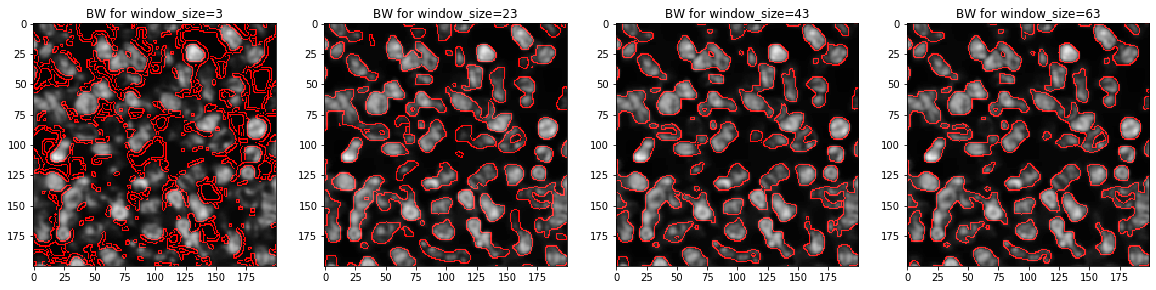

In [22]:
from skimage.filters import threshold_sauvola
fig, axes = plt.subplots(1, len(range(3, 64, 20)), figsize=(20, 10))
for idx, size in enumerate(range(3, 64, 20)):
    thresh_sauvola = threshold_sauvola(I_nuclei, window_size=size)
    BW_sauvola = I_nuclei > thresh_sauvola
    axes[idx].imshow(img_with_bw_boundaries(I_nuclei, BW_sauvola)[400:600, 400:600, :])
    axes[idx].set_title("BW for window_size=" + str(size))

**Выводы**
Наилучшим размером окна является 23, так как это не приводит к избыточности контуров и не приводит к размыканию областей в виде "пончиков"

In [23]:
thresh_sauvola = threshold_sauvola(I_nuclei, window_size=23)
BW_sauvola = I_nuclei > thresh_sauvola

### Triangle

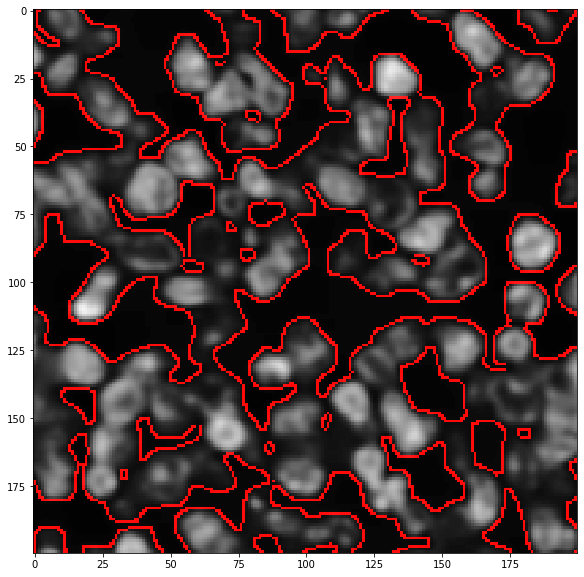

In [24]:
from skimage.filters import threshold_triangle
thresh_triangle = threshold_triangle(I_nuclei)
BW_triangle = I_nuclei > thresh_triangle
fig, axes = plt.subplots(figsize=(15, 10))
axes.imshow(img_with_bw_boundaries(I_nuclei, BW_triangle)[400:600, 400:600, :])

### Yen

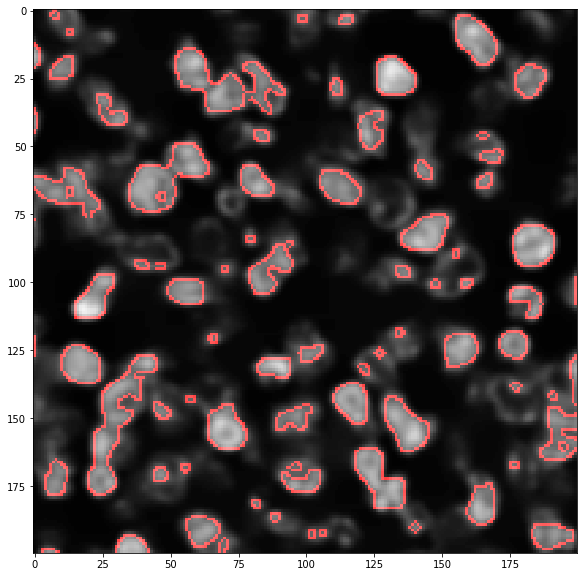

In [25]:
from skimage.filters import threshold_yen
thresh_yen = threshold_yen(I_nuclei)
BW_yen = I_nuclei > thresh_yen
fig, axes = plt.subplots(figsize=(15, 10))
axes.imshow(img_with_bw_boundaries(I_nuclei, BW_yen)[400:600, 400:600, :])

### Morphological Chan-Vese
Active contours without edges implemented with morphological operators. It can be used to segment objects in images and volumes without well defined borders. It is required that the inside of the object looks different on average than the outside (i.e., the inner area of the object should be darker or lighter than the outer area on average).

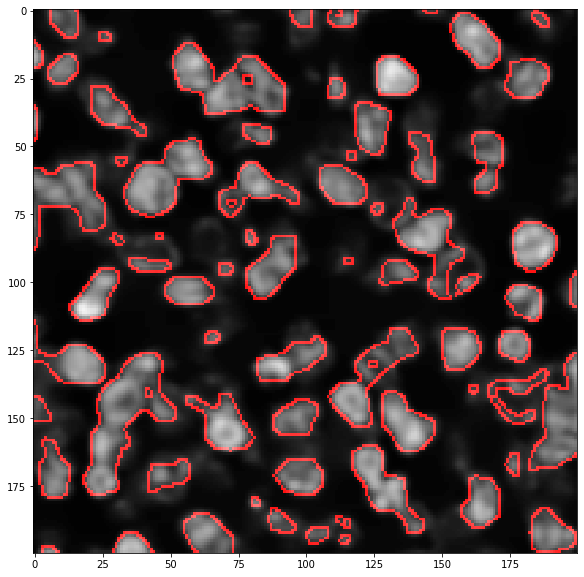

In [26]:
from skimage.segmentation import morphological_chan_vese
BW_chan_vese = morphological_chan_vese(I_nuclei, iterations=2) # При одной итерации явно проглядывает initial_level_set, при 3-х еще сильнее сжираются ядра
fig, axes = plt.subplots(figsize=(10, 10))
axes.imshow(img_with_bw_boundaries(I_nuclei, np.array(BW_chan_vese, dtype=bool))[400:600, 400:600, :])

### Morphological GAC
Geodesic active contours implemented with morphological operators. It can be used to segment objects with visible but noisy, cluttered, broken borders.

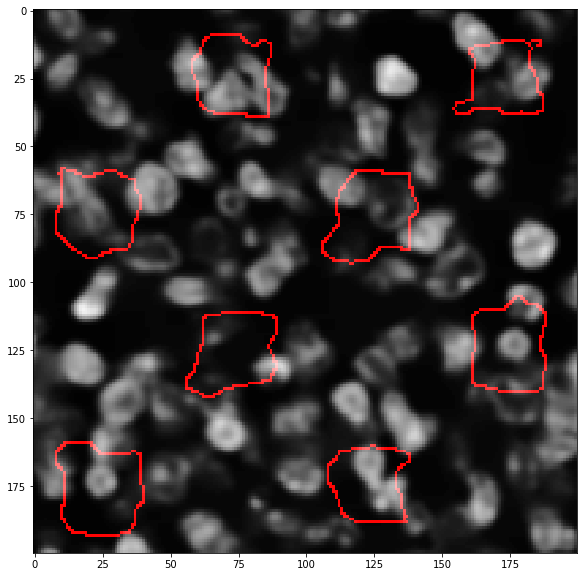

In [28]:
from skimage.segmentation import morphological_geodesic_active_contour, inverse_gaussian_gradient, checkerboard_level_set

gimage = inverse_gaussian_gradient(I_nuclei)

# Initial level set
init_ls = np.zeros(I_nuclei.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
init_ls = checkerboard_level_set(I_nuclei.shape, 50)

BW_GAC = morphological_geodesic_active_contour(gimage, 10, init_ls, threshold='auto', balloon=-2)

fig, axes = plt.subplots(figsize=(10, 10))
axes.imshow(img_with_bw_boundaries(I_nuclei, np.array(BW_GAC, dtype=bool))[400:600, 400:600, :])

Требуется задание адекватного начального приближения контуров и дальнейшее применение GAC, так как при варьировании параметров не удалось добиться хоть сколько угодно адекватной сегментации. А также данному методу требуется большое число итераций для определения различных объектов, попавших в общий исходный контур, также плохо справляется с размытыми границами.

### Felzenszwalb
Параметр scale подбирался для снижения числа ложных контуров и при этом адекватной сегментации.
Стоит отметить, что при scale порядка 200-300 данный метод дает много контуров, из которых в дальнейшем возможно получить хорошее разделение кластеров

Text(0.5, 1.0, "Felzenszwalbs's method")

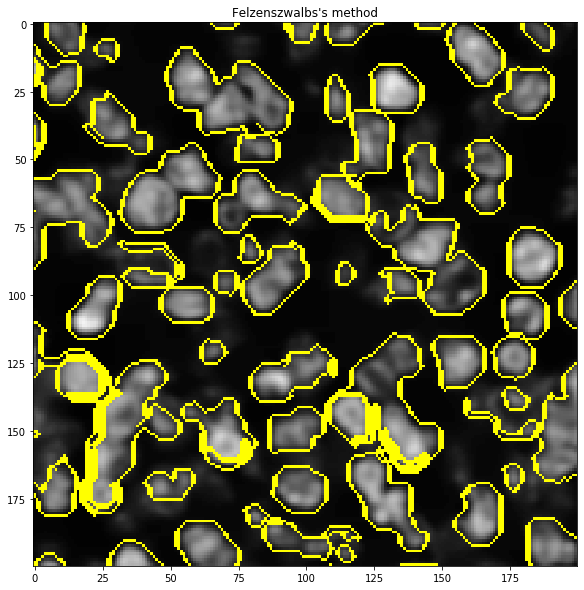

In [29]:
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
segments_fz = felzenszwalb(I_nuclei, scale=400, multichannel=False)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mark_boundaries(I_nuclei, segments_fz)[400:600, 400:600])
ax.set_title("Felzenszwalbs's method")

### SLIC
Не подходит для серошкальных изображений, но преобразуем серошкальное в RGB. Однако требует число сегментов, что не является априорной информацией. ВОзможно в дальнейшем использовать для разделения кластеров с площадью более площади одного ядра.

Text(0.5, 1.0, 'SLIC method')

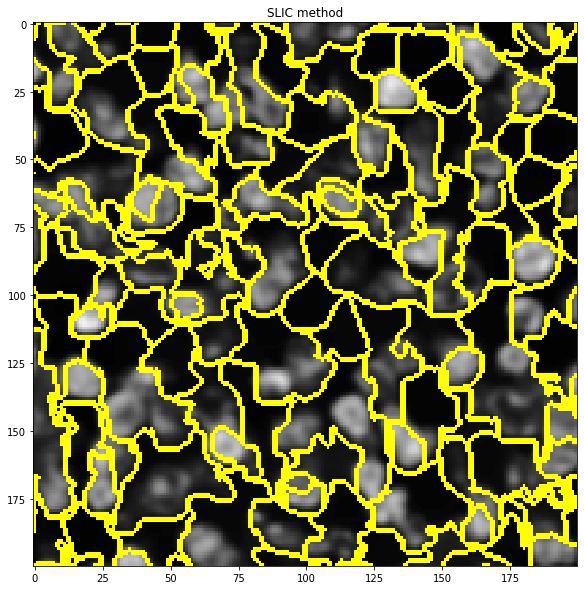

In [30]:
from skimage.segmentation import slic
from skimage.color import gray2rgb
segments_slic = slic(gray2rgb(I_nuclei), n_segments=20000, compactness=1, sigma=1)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mark_boundaries(I_nuclei, segments_slic)[400:600, 400:600])
ax.set_title("SLIC method")

### QuickShift

Text(0.5, 1.0, 'SLIC method')

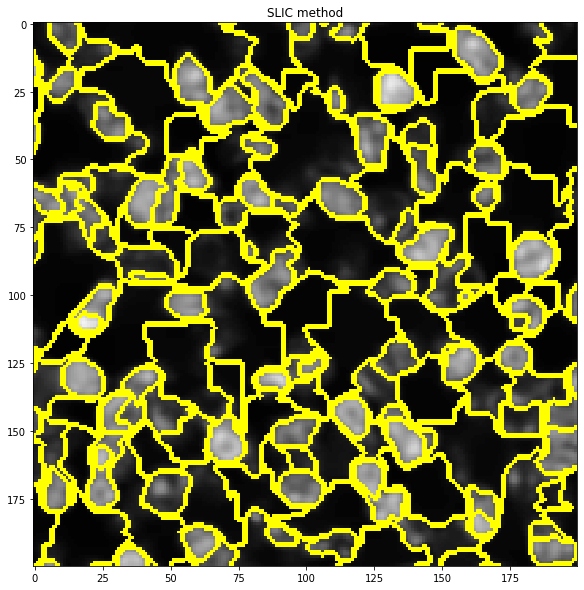

In [31]:
from skimage.segmentation import quickshift, watershed
segments_quick = quickshift(gray2rgb(I_nuclei), kernel_size=3, max_dist=6, ratio=0.5)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mark_boundaries(I_nuclei, segments_quick)[400:600, 400:600])
ax.set_title("SLIC method")

### Watershed

Text(0.5, 1.0, 'SLIC method')

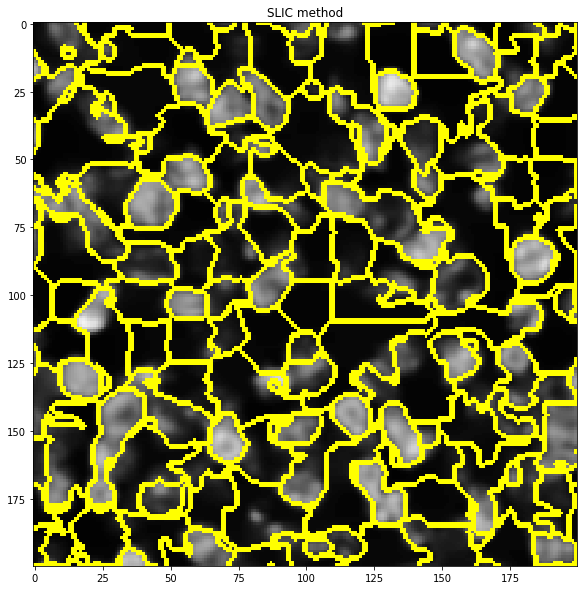

In [32]:
from skimage.segmentation import watershed
from skimage.filters import sobel
gradient = sobel(I_nuclei)
segments_watershed = watershed(gradient, markers=10000, compactness=0.001)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mark_boundaries(I_nuclei, segments_watershed)[400:600, 400:600])
ax.set_title("SLIC method")

# Выводы
Метод бинаризации *ISODATA* и *Li* дают разбиение единого ядра на небольшие фрагменты в достаточно большом числе случаев, что в дальнейшем затруднит разделение кластеров и приведет к неадекватному подсчету статистики мембранных маркеров.<br/>
<br/>
Метод *адаптивной (локальной) бинаризации* требует подбора ряда параметров и вычисляется за весьма ощутимое время при выборе медианного фильтра, так как он требует применения сортировки и при большом размере окна данная операция будет сильно затратной.
Метод бинаризации *Mean*, как и метод *Minimum* и *Otsu*, из-за своей реализации не могут уловить локальных изменений контрастов ядер, что приводит к неадекватному улавливанию контуров ядер. Также остальные методы, основанные на анализе гистограмм (*Triangle, Yen*) не могут адекватно справиться с задачей сегментации. Однако стоит отметить, что Triangle дает маску с достаточным запасом и, возможно, при применении алгоритма активных контуров он даст неплохой результат.<br/>
<br/>
Методы активных контуров (*Chan Vese, Morphological Geodesic Active Contours и Morphological Active Contours without Edges*) сходятся неравномерно из-за неравномерности градиента вблизи границ ядер, поэтому маска части ядер слишком уходит внутрь ядра.<br/>
<br/>
Методы определения суперпикселей (*Felzenszwalb, Quickshift, SLIC, Watershed*) не дают точной оценки границ ядер и некоторые из них требует достаточно длительной оптимизации гиперпараметров. Однако возможно дальнейшее улучшение путем оценки среднего значения и разброса интенсивности с последующим удалением однородных темных кластеров.<br/>
<br/>
***Наилучшими*** после просмотра работы всех алгоритмов на целом изображении далее могут быть использованы triangle и yen (последний с дополнительной морфологической обработкой). Данные методы хороши тем, что не требуют никакой оптимизации параметров, а также хорошо справляются с неоднородностью интенсивности ядер в виду их залегания вне фокальной плоскости. Однако в процессе поиска решения задачи разбиения кластеров был найден неплохой нейросетевой подход для получения сразу лэйбованного изображения, в ноутбуке с разбиением кластеров данный алгоритм будет рассмотрен и результат сегментации с его использованием будет сохранен в ту же папку, что и текущие результаты сегментации<br/>

In [44]:
# Сохранение полученных результатов сегментаций ядер в папку BW_nuclei
from save_imgs_to_folder import *
BW_local = I_nuclei > threshold_local(I_nuclei, block_size=101, method='median')
bws = [BW_isodata, BW_li, BW_local, BW_mean, BW_minimum, BW_niblack, BW_otsu, BW_sauvola, BW_triangle, BW_yen, BW_chan_vese, BW_GAC]
bws_names = ['isodata', 'local', 'mean', 'minimum', 'niblack', 'otsu', 'sauvola', 'triangle', 'yen', 'chan_vese', 'GAC']
bws_ext = '.tif'
bws_names = ['BW_nuclei_' + bw_name + imgs_ext for bw_name in bws_names]
bws = [np.uint8(bw) * 255 for bw in bws]
save_imgs_to_folder(bws, imgs_names, r'tiled_data\BW_nuclei')

In [45]:
# Сохранение полученных результатов сегментаций ядер в папку BW_nuclei_on_img
from save_imgs_to_folder import *
bws = [BW_isodata, BW_li, BW_local, BW_mean, BW_minimum, BW_niblack, BW_otsu, BW_sauvola, BW_triangle, BW_yen, BW_chan_vese, BW_GAC]
bws_names = ['isodata', 'local', 'mean', 'minimum', 'niblack', 'otsu', 'sauvola', 'triangle', 'yen', 'chan_vese', 'GAC']
bws_ext = '.tif'
bws_names = ['BW_nuclei_' + bw_name + imgs_ext for bw_name in bws_names]
bws = [img_with_bw_boundaries(I_nuclei, np.array(bw, dtype=bool)) for bw in bws]
save_imgs_to_folder(bws, imgs_names, r'tiled_data\BW_nuclei_on_img')